# Hands on Counterfit to compromise ML models using adverserial attacks - Hands-on-tutorials

There are a lot of different ways to compromise machine learning models using adverserial attacks.
Here are few exemples : 
- Confidence reduction : when we make the model less confident in its predictions
- Misclassification : when we make the model no longer able to correctly classify an input
- Targeted Misclassification : when we force to model to misclassify an input with a different, but selected, target
  
In this jupyter notebook we will see how to compromise ML models using Counterfit and performing a misclassification attack on the Fashion MNIST dataset.

## Counterfit

Counterfit is a command-line tool that provides a generic automation layer for adversarial AI frameworks such as [Adversarial Robustness Toolbox](https://github.com/Trusted-AI/adversarial-robustness-toolbox) and [Text Attack](https://github.com/QData/TextAttack). This tool will allow us to implement our attack scenario of a simple machine learning model and we will see below how to proceed step by step.

Available on this [GitHub repository](https://github.com/Azure/counterfit).

## Scenario

When planning a machine learning model attack scenario, it is important to consider how much access we have to the model in question. The answer to this question allows us to know what type of attack we will be able to implement.

If we don't have access to the structure of the model nor to its parameters, we can carry out a **black-box attack** by observing the answer of the model to different inputs. After some iterations of a black-box attack algorithm we are likely to converge to an input which will be missclassified by the model. On the other hand, if we have access to the model and its parameters, it will be possible to implement a **white-box attack** which is more specific.

In our example, we will perform two different attacks using Counterfit:

* [HopSkipJump](https://arxiv.org/abs/1904.02144) which is a black-box attack
* [Carlini L inf](https://arxiv.org/abs/1608.04644) which is a white-box attack

At the end, we will interpret and compare the two results obtained.

## First step: create and train our vanilla ML model on Fashion MNIST dataset
In the cells below, we will create our ML model trained on the Fashion MNIST dataset. 
Our model has to be able to correctly cassify any input in one of the 10 total classes.

This model will be the one we'll try to compromise using adverserial attacks.

**Import packages**

In [ ]:
# !pip install tensorflow

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**Get the dataset and preprocess it**

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


**Define our ML model**

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

**Train the model**

In [ ]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/15
422/422 [==============================] - 28s 64ms/step - loss: 0.6940 - accuracy: 0.7484 - val_loss: 0.4445 - val_accuracy: 0.8425
Epoch 2/15
422/422 [==============================] - 27s 64ms/step - loss: 0.4525 - accuracy: 0.8380 - val_loss: 0.3844 - val_accuracy: 0.8627
Epoch 3/15
422/422 [==============================] - 27s 65ms/step - loss: 0.4015 - accuracy: 0.8582 - val_loss: 0.3534 - val_accuracy: 0.8718
Epoch 4/15
422/422 [==============================] - 28s 65ms/step - loss: 0.3746 - accuracy: 0.8648 - val_loss: 0.3326 - val_accuracy: 0.8820
Epoch 5/15
422/422 [==============================] - 28s 66ms/step - loss: 0.3511 - accuracy: 0.8734 - val_loss: 0.3188 - val_accuracy: 0.8842
Epoch 6/15
422/422 [==============================] - 29s 68ms/step - loss: 0.3353 - accuracy: 0.8802 - val_loss: 0.2974 - val_accuracy: 0.8925
Epoch 7/15
422/422 [==============================] - 29s 69ms/step - loss: 0.3245 - accuracy: 0.8830 - val_loss: 0.2918 - val_accuracy:

**Save the trained model**

In [ ]:
model.save("fashion_mnist_model.h5")

**Load the model**

In [ ]:
model = keras.models.load_model("fashion_mnist_model.h5")

# Second step : compromise our model
Now that we have a working model, we will use Counterfit to implement our two attack scenarios and observe what the results are.
In this part, we will use Counterfit to perform a misclassification attack on our ML model.

To be more precise, we will implement two misclassification scenarios on a class 4 image. The objective is to generate an image for each attack scenario that looks very similar to the initial image but that will be misclassified by the model.

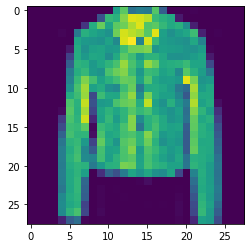

In [ ]:
img = mpimg.imread('results/original_fashion_mnist_index10.png')
plt.imshow(img)
plt.show()

In [ ]:
img_reshape = np.reshape(img, (1, 28, 28))
print("Original label: {}".format(np.argmax(model.predict(img_reshape))))

Original label: 4


The image above belongs to class 4.

Let's see how to run Counterfit on this image !

- **Install Counterfit**

To install Counterfit, you can follow the instructions given in the *README.md* here : https://github.com/Azure/counterfit/

Once Counterfit is installed, we can prepare the attack.

- **Create the target directory**

Go to *./counterfit/targets/* and create a directory, say *fashion_mnist*.

```
$ cd ./counterfit/targets
$ mkdir fashion_mnist
```

Put the saved model, *fashion_mnist_model.h5*in this directory.

- **Make the model reachable by Counterfit**

In order to perform the attack, the model has to be reachable by Counterfit.
To do so, we need to write a small script which we'll be named *fashion_mnist.py*.
Please, make sure you save this file in the right directory (*./counterfit/targets*). 

Alternatively, the *new* command can be used.


Here's the content of *fashion_mnist.py*:

```python
import os
import tensorflow as tf
from tensorflow import keras as K
import numpy as np

from counterfit.core.targets import CFTarget

# for ART
tf.compat.v1.disable_eager_execution()


class FashionKeras(CFTarget):
    data_type = "image"
    target_name = "fashion_mnist"
    endpoint = "fashion_mnist/fashion_mnist_model.h5"
    input_shape = (28, 28, 1)
    output_classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    classifier = "keras"
    X = []

    def load(self):
        if not os.path.isfile(self.fullpath(self.endpoint)):
            print("[!] Model file not found!")
        else:
            self.model = K.models.load_model(
                self.fullpath(self.endpoint))
        (train_x, train_y), (test_x, test_y) = K.datasets.fashion_mnist.load_data()

        self.X = test_x.astype(np.float32) / 255.  # float type [0,1]
        self.X = self.X.reshape(-1, 28, 28, 1)

    def predict(self, x):
        x = (x.reshape(-1, 28, 28, 1) * 255).astype(int).astype(float)/255.  # accept as quantized image
        pred_probs = self.model.predict(x)
        return pred_probs
```

We also need to add *FashionKeras* in the *targets* variable in examples/terminal/core/state.py. 

We have to add the line below in *counterfit/targets/__init__.py* : 

```python 
from .fashion_mnist import FashionKeras
```

Now, we are ready to perform our adverserial attack !

- **Open Counterfit**

```
$ counterfit
```

- **List targets and select fashion_mnist**

```
counterfit> list targets
counterfit> set_target fashion_mnist
```

- **List possible attacks** 

```
fashion_mnist> list attacks
```

- **Let's try first with a white-box attack : *CarliniLInfMethod* attack**

```
fashion_mnist> set_attack carlini
fashion_mnist>CarliniLInfMethod> set_params --eps 0.15 --learning_rate 0.1 --max_iter 10 --sample_index 18
fashion_mnist>CarliniLInfMethod> run
```

- **Compare with an black-box attack. We'll use *HopSkipJump* with default parameters**

```
fashion_mnist>CarliniLInfMethod> exit attack
fashion_mnist> set_attack HopSkipJump
fashion_mnist>HopSkipJump> set_params --sample_index 18 --max_eval 1250 --max_iter 5 --norm inf
fashion_mnist>HopSkipJump> run
```

# Results

Our two images have been generated, let's see the results!

**Original image**

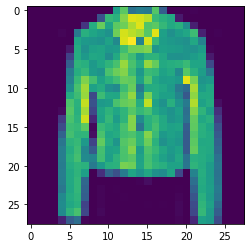

In [ ]:
original_img = mpimg.imread('results/original_fashion_mnist_index10.png')
plt.imshow(original_img)
plt.show()

In [ ]:
original_img_reshape = np.reshape(original_img, (1, 28, 28))
print("Original label: {}".format(np.argmax(model.predict(original_img_reshape))))

Original label: 4


**White-box adverserial attack : CarliniLInf Method**

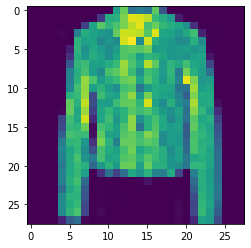

In [ ]:
carlinilinf_img = mpimg.imread('results/carlinilinf_fashion_mnist_index10_new6.png')
plt.imshow(carlinilinf_img)
plt.show()

In [ ]:
carlinilinf_img_reshape = np.reshape(carlinilinf_img, (1, 28, 28))
print("New classification after CarliniLInf method attack: {}".format(np.argmax(model.predict(carlinilinf_img_reshape))))

New classification after CarliniLInf method attack: 6


It is noticeable that the resulting image of the white-box attack is really similar to the original image. It is almost indistinguishable from the original with the naked eye. 

Out of curiosity, we can highlight the pixels that have been modified by displaying the difference between the modified image and the original image.

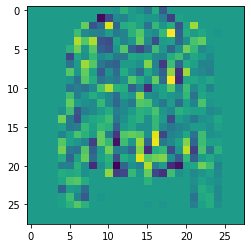

In [ ]:
plt.imshow(carlinilinf_img - original_img)
plt.show()

**Black-box adverserial attack: HopSkipJump Method**

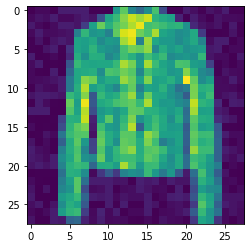

In [ ]:
hopskipjump_img = mpimg.imread('results/hopskipjump_fashion_mnist_index10_new6.png')
plt.imshow(hopskipjump_img)
plt.show()

In [ ]:
hopskipjump_img_reshape = np.reshape(hopskipjump_img, (1, 28, 28))
print("New classification after HopSkipJump method attack: {}".format(np.argmax(model.predict(hopskipjump_img_reshape))))

New classification after HopSkipJump method attack: 6


The resulting image of the black-box attack looks more noisy. However, the overall appearance of the image and what is represented in it is still reminiscent of the original image.

Again, we can highlight the pixels that have been modified by displaying the difference between the modified image and the original image.

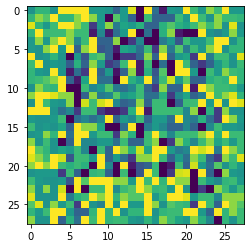

In [ ]:
plt.imshow(hopskipjump_img - original_img)
plt.show()

# Conclusion

Through this notebook, we shown how easy it can be to perform adversarial attacks on models using Counterfit, whether it is a white box or black box attack.

Although this notebook is not a formal proof, we can still hypothesize that white-box attacks can achieve better results than black-box attacks. And this can be explained quite simply by the fact that in black-box attacks we have much less information to create our custom input than in white-box attacks.

To protect the model from this type of attack, it is possible to follow the [Microsoft Security Development Lifecycle (SDL)](https://www.microsoft.com/en-us/securityengineering/sdl/) or at least some of the [practices](https://www.microsoft.com/en-us/securityengineering/sdl/practices) that give interesting leads.

[Practice #4](https://www.microsoft.com/en-us/securityengineering/sdl/threatmodeling) consists in performing a Threat Modeling. This allows us to make a structured analysis of the potential risks on our system.



![Threat Modeling](threats.png)

The image above shows the result of Threat Modeling on a very simplified version of our system where we would deploy our model in the cloud as an API and it would be callable by IoT Devices like connected cameras.

We see that there are several important information points to take into account to ensure an minimum of security. In our problem, if we want to avoid adverserial attacks, we can focus our attention on these lines :
* An adversary may inject malicious inputs into an API and affect downstream processes
* If proper authentication is not in place, an adversary can spoof a source process or external entity and gain unauthorized access to the Web Application

The Modeling Threat tool shows us that we might encouter security issue if we don't control user inputs and if we run the service without authentication. With that said, it appears to be a good idea to restrict the access to the model itself by authenticating each user and by setting a limit in the number of request made to the model in order to limit the possibility of performing adverserial attacks.
